In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
df = pd.read_csv("bitcoin.csv")
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28 00:00:00.000,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00.000,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00.000,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00.000,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00.000,103.43,1.148668e+09,0.0


In [27]:
# 100x logged returns
df['returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['returns_scaled'] = np.multiply(df['returns'], 100)

In [28]:
returns = pd.DataFrame(df['returns'].dropna())

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.400e+01, 1.130e+02, 1.572e+03,
        1.974e+03, 1.350e+02, 1.400e+01, 1.000e+00]),
 array([-0.43371443, -0.36163308, -0.28955173, -0.21747037, -0.14538902,
        -0.07330767, -0.00122632,  0.07085503,  0.14293638,  0.21501774,
         0.28709909]),
 <BarContainer object of 10 artists>)

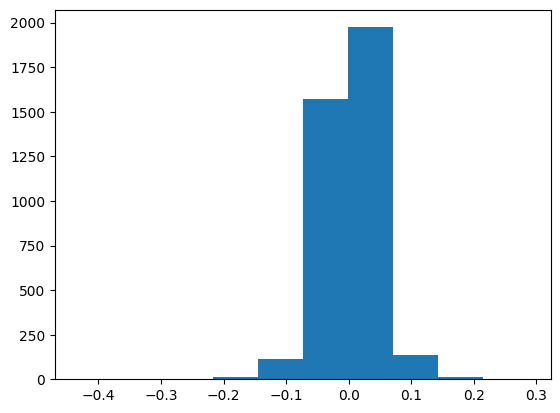

In [34]:
plt.hist(returns['returns'])

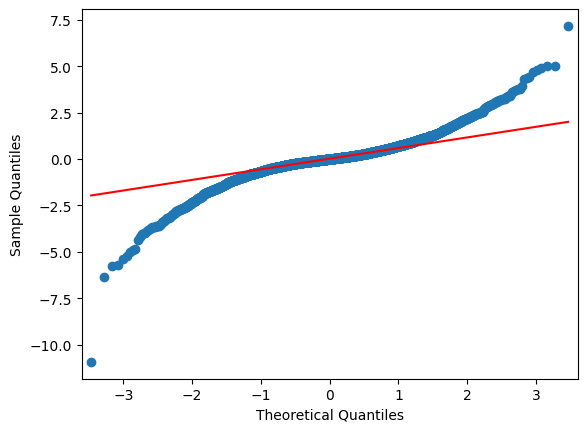

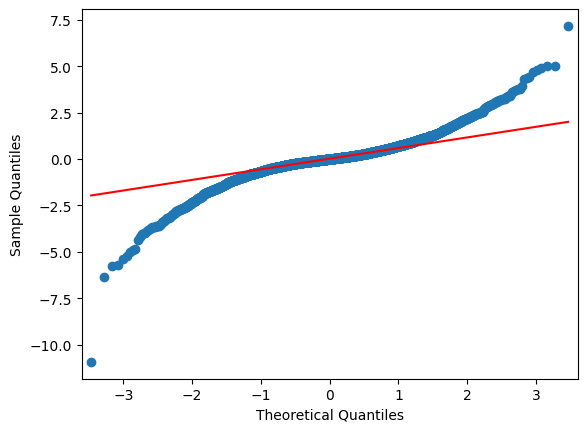

In [36]:
qqplot(returns['returns'], line='q', fit=True)

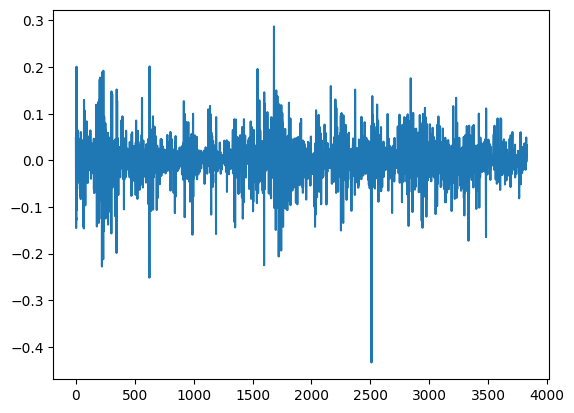

In [37]:
plt.plot(returns['returns'])

In [40]:
from arch import arch_model


In [43]:
m = arch_model(returns['returns'], mean='AR', vol='GARCH', p=1, q=1, lags=3, dist='ged')
r = m.fit(disp=False, options={'ftol': 1e-01})
r.summary()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.001
Mean Model:                                    AR   Adj. R-squared:                 -0.000
Vol Model:                                  GARCH   Log-Likelihood:                7640.10
Distribution:      Generalized Error Distribution   AIC:                          -15264.2
Method:                        Maximum Likelihood   BIC:                          -15214.2
                                                    No. Observations:                 3824
Date:                            Sun, Nov 12 2023   Df Residuals:                     3820
Time:                                    14:16:32   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       1.2236e-03  3.458e-04      3.538  4.026e-04  [5.459e-04,1.901e-03]
returns[1] -5.0170e-03  2.185e-02     -0.230      0.818 [-4.784e-02,3.781e-02]
returns[2] -6.3720e-03  1.455e-02     -0.438      0.661 [-3.489e-02,2.215e-02]
returns[3]      0.0221  1.398e-02      1.580      0.114 [-5.315e-03,4.947e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.1512e-05  4.930e-06      6.392  1.641e-10 [2.185e-05,4.117e-05]
alpha[1]       0.1000  2.017e-02      4.957  7.146e-07   [6.046e-02,  0.140]
beta[1]        0.8800  1.484e-02     59.314      0.000     [  0.851,  0.909]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.183      8.178  2.883e-16 [  1.141,  1.859]
========================================================================

Covariance estimator: robust
"""

In [44]:
# Plot functions
def tsplot(y, y_2, lags=None, title='', figsize=(18, 8)):  # source code: https://tomaugspurger.github.io/modern-7-timeseries.html
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ts2_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y_2.plot(ax=ts2_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, ts2_ax, acf_ax, pacf_ax

# Performance evaluation
def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot(figsize=(18,5))
    ax.xaxis.label.set_visible(False)
    return

In [50]:
kline_test = pd.DataFrame(df['prices'])
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['prices'])  # Calculate the daily logarithmic rate of return
kline_test['return'] = kline_test['log_price'].pct_change().dropna()
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # Calculate the logarithmic rate of return
kline_test['squared_log_return'] = np.power(kline_test['log_return'], 2)  # Exponential square of log daily return rate

kline_test['return_100x'] = np.multiply(kline_test['return'], 100)
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # Enlarge 100 times

kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum().copy() # Resampling to days 
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # Volatility of variance derivation

kline_test = kline_test[4:-2500]
kline_test.head(3)

NameError: name 'kline_1m' is not defined

In [ ]:
cc = 3
model_p = 1
predict_lag = 30
label = 'log_return'

training_label = label
training_ts = pd.DataFrame(kline_test[training_label])

training_arch_label = label
training_arch = pd.DataFrame(kline_test[training_arch_label])

training_garch_label = label
training_garch = pd.DataFrame(kline_test[training_garch_label])

training_egarch_label = label
training_egarch = pd.DataFrame(kline_test[training_egarch_label])

training_arch.plot(figsize = (18,4))


In [49]:
def recursive_forecast(pd_dataframe):     
    window = predict_lag
    model = 'GARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged',p=1, q=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))

recursive_forecast(kline_test)

KeyError: 'log_return'